In [15]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

## Data -- Generation

In [16]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 2
num_attr_vals = 8
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 64 unqiue cards
Generated 2016 cardpairs
-- 448 cardpairs with shared concept
-- 1568 cardpairs without shared concept
[(0, 1568), (1, 448)]
Total number of matches =  3584
Number of shared concepts per match =  [(1, 3584)]


## Data -- Distribution, Splits

In [17]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [18]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(1e-100, 125440), (0.00027901785714285713, 3584)]

In [19]:
np.sum(count_table)

3584.0

In [20]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 15
xy_div_xyind_rank= 15


In [48]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))
# figrange = (0, len(game_data['idx_to_key']), 0, 300)

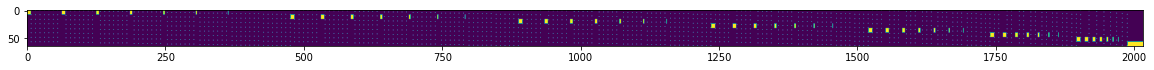

In [49]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

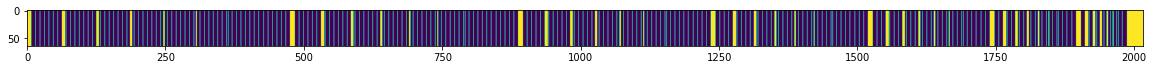

In [50]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

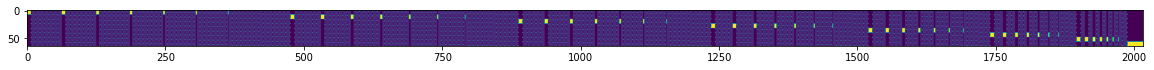

In [51]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

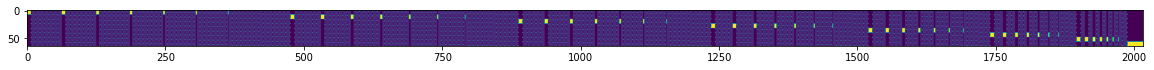

In [52]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [26]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(0.9999999999999988, 64288),
 (0.9999999999999986, 21952),
 (2.8672000000000013e-96, 19600),
 (0.9999999999999989, 14112),
 (2.867200000000001e-96, 5488),
 (8.000000000000004, 2800),
 (8.000000000000002, 784)]

## Dataset

In [27]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[10] 
print('-----')
game_dataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('green', 'checkered')
key
 0 ('red', 'void')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'void')
key
 0 ('red', 'void')
all matches 
 [('red', 'void'), ('green', 'void'), ('blue', 'void'), ('orange', 'void'), ('cyan', 'void'), ('magenta', 'void'), ('black', 'void'), ('yellow', 'void')]


(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]))

In [28]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        queries_with_shared_attr_only: bool.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
            
            
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[10]
print('-----')
game_testdataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('green', 'checkered')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'void')
all matches 
 [('red', 'void'), ('green', 'void'), ('blue', 'void'), ('orange', 'void'), ('cyan', 'void'), ('magenta', 'void'), ('black', 'void'), ('yellow', 'void')]


(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]))

In [29]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
#         self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
#         if stage == 'test' or stage is None:
#             self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
#     def test_dataloader(self):
#         test_loader = DataLoader(
#             self.test, batch_size=self.batch_size, shuffle=False
#         )
#         return test_loader  

## Model Architecture

In [30]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict([   
                ('linear1', nn.Linear(2*hparams['d_model'], hparams['d_model'])),
                ('nonLinear1', nn.ReLU()),
                ('linear-out', nn.Linear(hparams['d_model'], 1)),
            ])
        ) if not hparams['dotproduct_bottleneck'] else None, 
        
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [31]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [32]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [33]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [34]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        total_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
            # filter down to query cards with >0 true matches
            queryIdxs_with_nonzero_matches = list(self.raw_data['query_to_keys'].keys())
            X_query_flat = X_query.squeeze(-1)
            fil = torch.stack([(X_query_flat == qId) for qId in queryIdxs_with_nonzero_matches], dim=1).any(dim=1)
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [35]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

thresholded_metrics = ThresholdedMetrics(raw_data=game_data)

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        try:
            assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
        except:
            import pdb; pdb.set_trace()
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [36]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    # game difficulty
    'num_attributes': num_attributes,
    'num_attr_vals': num_attr_vals,
    # distribution
    'distribution_epsilon': distribution_epsilon,
    'xy_size': xy.shape,
    # 
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 4,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':True,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind})# , raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = 'CardGame:OR;attr{}-val{};epsilon{};d_model{};params{}K-dotproduct'.format(num_attributes, num_attr_vals, str(distribution_epsilon), hparams['d_model'], round(max(model_summary.param_nums)/1000,2))
project_name = 'ContrastiveLearning-cardgame-Scaling'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)
# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)

Global seed set to 42


   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 8.3 K 
1  | model.inp_query_layer                        | Sequential         | 8.1 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 8.1 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 8.1 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 256   
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 256   
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 256   
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                      

## Run Training

In [ ]:
# checkpoints
os.makedirs(ckpt_dir_PATH, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

# trainer
trainer = pl.Trainer(
    gpus=[0], 
    min_epochs=2, max_epochs=60000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

#fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory checkpoints/ContrastiveLearning-cardgame-Scaling/CardGame:OR;attr2-val8;epsilon1e-100;d_model4;params8.32K-dotproduct exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-23-6299eb7a09a4>:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


wandb: WARNING Serializing object of type ndarray that is 1032304 bytes
wandb: WARNING Serializing object of type ndarray that is 1032304 bytes

   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 8.3 K 
1  | model.inp_query_layer                        | Sequential         | 8.1 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 8.1 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 8.1 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 256   
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 256   
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 256   
8  | loss_criterion                              

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                        

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=620, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/

Validating: 0it [00:00, ?it/s]
Epoch 68:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 69:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 70:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 71:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 72:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 73:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 74:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 75:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=621, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 76:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=621, v_num=mr3c]
Validating: 0it [00

Validating: 0it [00:00, ?it/s]
Epoch 135:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=620, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 136:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=620, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 137:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=620, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 138:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=620, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 139:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=620, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 140:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=620, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 141:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=620, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 142:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=620, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 143:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=620, v_num=mr3c]
Validating

Epoch 201:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=618, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 202:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=618, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 203:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=618, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 204:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=618, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 205:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=618, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 206:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=618, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 207:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=617, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 208:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=617, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 209:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=617, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 210:

Epoch 268:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=614, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 269:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=614, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 270:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=614, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 271:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=614, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 272:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=614, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 273:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=614, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 274:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=614, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 275:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=613, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 276:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=613, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 277:

Validating: 0it [00:00, ?it/s]
Epoch 335:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=608, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 336:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=608, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 337:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=608, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 338:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=608, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 339:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=607, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 340:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=607, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 341:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=607, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 342:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=607, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 343:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=607, v_num=mr3c]
Validating

Epoch 401:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=600, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 402:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=600, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 403:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=600, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 404:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=600, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 405:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=600, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 406:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=600, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 407:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=599, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 408:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=599, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 409:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=599, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 410:

Epoch 468:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=588, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 469:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=588, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 470:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=588, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 471:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=588, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 472:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=587, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 473:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=587, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 474:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=587, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 475:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=587, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 476:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=587, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 477:

Validating: 0it [00:00, ?it/s]
Epoch 535:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=574, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 536:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=574, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 537:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=574, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 538:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=574, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 539:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=573, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 540:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=573, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 541:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=573, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 542:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=573, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 543:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=572, v_num=mr3c]
Validating

Epoch 601:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=560, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 602:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=559, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 603:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=560, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 604:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=559, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 605:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=558, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 606:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=558, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 607:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=558, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 608:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=558, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 609:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=557, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 610:

Epoch 668:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=548, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 669:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=548, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 670:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=548, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 671:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=547, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 672:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=546, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 673:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=546, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 674:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=546, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 675:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=546, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 676:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=546, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 677:

Validating: 0it [00:00, ?it/s]
Epoch 735:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=535, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 736:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=535, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 737:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=535, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 738:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=535, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 739:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=534, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 740:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=534, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 741:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=535, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 742:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=534, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 743:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=534, v_num=mr3c]
Validating

Epoch 801:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=524, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 802:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=523, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 803:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=523, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 804:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=523, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 805:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=523, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 806:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=523, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 807:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=524, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 808:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=524, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 809:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=524, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 810:

Epoch 868:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=514, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 869:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=513, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 870:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=513, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 871:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=513, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 872:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=513, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 873:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=513, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 874:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=514, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 875:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=514, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 876:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=514, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 877:

Validating: 0it [00:00, ?it/s]
Epoch 935:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=506, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 936:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=506, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 937:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=507, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 938:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=506, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 939:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=507, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 940:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=506, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 941:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=506, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 942:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=506, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 943:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=507, v_num=mr3c]
Validating

Epoch 1001:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=501, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1002:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=502, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1003:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=502, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1004:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=501, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1005:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=501, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1006:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=501, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1007:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=501, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1008:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=502, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1009:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=502, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 1067:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=497, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1068:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=497, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1069:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=495, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1070:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=496, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1071:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=496, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1072:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=495, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1073:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=496, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1074:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=495, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1075:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=495, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 1133:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=489, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1134:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=488, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1135:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=488, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1136:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=488, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1137:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s, loss=489, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1138:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=488, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1139:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=488, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1140:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=488, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1141:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=488, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 1200:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=489, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1201:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=488, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1202:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=489, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1203:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=489, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1204:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=488, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1205:  50%|█████     | 1/2 [00:00<00:00,  2.56it/s, loss=488, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1206:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=488, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1207:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=488, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1208:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=487, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 1266:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=485, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1267:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=484, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1268:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=485, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1269:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=485, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1270:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=485, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1271:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=485, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1272:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=486, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1273:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=485, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1274:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=485, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1333:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=484, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1334:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=483, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1335:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=483, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1336:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=482, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1337:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=482, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1338:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=482, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1339:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=482, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1340:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=481, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1341:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=481, v_num=mr3c]
V

Epoch 1399: 100%|██████████| 2/2 [00:00<00:00,  2.49it/s, loss=479, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1400:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=479, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1401:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=479, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1402:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=479, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1403:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=480, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1404:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=480, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1405:  50%|█████     | 1/2 [00:00<00:00,  2.70it/s, loss=481, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1406:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=481, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1407:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=481, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 1466:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=477, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1467:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=478, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1468:  50%|█████     | 1/2 [00:00<00:00,  2.86it/s, loss=478, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1469:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=477, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1470:  50%|█████     | 1/2 [00:00<00:00,  2.99it/s, loss=477, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1471:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=478, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1472:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=478, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1473:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=478, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1474:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=478, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 1532:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=478, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1533:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=478, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1534:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=476, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1535:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=477, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1536:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=476, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1537:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=476, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1538:  50%|█████     | 1/2 [00:00<00:00,  2.79it/s, loss=477, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1539:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=476, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1540:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=476, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 1598:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=476, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1599: 100%|██████████| 2/2 [00:00<00:00,  4.70it/s, loss=476, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1600:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=476, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1601:  50%|█████     | 1/2 [00:00<00:00,  2.80it/s, loss=476, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1602:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=475, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1603:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=475, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1604:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=475, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1605:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=475, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1606:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=476, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 1664:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=469, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1665:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=468, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1666:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=469, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1667:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=468, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1668:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=468, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1669:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=469, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1670:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=469, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1671:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=469, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1672:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=470, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 1730:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=471, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1731:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=471, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1732:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=470, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1733:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=470, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1734:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=470, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1735:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=470, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1736:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=470, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1737:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=471, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1738:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=470, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 1796:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=468, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1797:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=469, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1798:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=469, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1799: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s, loss=468, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1800:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=469, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1801:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=469, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1802:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=469, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1803:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=468, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1804:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=468, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 1862:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=471, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1863:  50%|█████     | 1/2 [00:00<00:00,  2.57it/s, loss=471, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1864:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=471, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1865:  50%|█████     | 1/2 [00:00<00:00,  2.07it/s, loss=471, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1866:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=471, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1867:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=471, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1868:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=470, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1869:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=471, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1870:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=470, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 1928:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=464, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1929:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=464, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1930:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=465, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1931:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=465, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1932:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=466, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1933:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=466, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1934:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=466, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1935:  50%|█████     | 1/2 [00:00<00:00,  2.57it/s, loss=466, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1936:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=467, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 1994:  50%|█████     | 1/2 [00:00<00:00,  2.59it/s, loss=463, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1995:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=463, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1996:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=463, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1997:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=463, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1998:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=463, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 1999: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s, loss=463, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2000:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=464, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2001:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=464, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2002:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=464, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 2060:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=465, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2061:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=465, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2062:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=465, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2063:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=465, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2064:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=465, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2065:  50%|█████     | 1/2 [00:00<00:00,  2.70it/s, loss=466, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2066:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=466, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2067:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=466, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2068:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=466, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 2126:  50%|█████     | 1/2 [00:00<00:00,  2.55it/s, loss=464, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2127:  50%|█████     | 1/2 [00:00<00:00,  2.99it/s, loss=464, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2128:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=464, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2129:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=464, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2130:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=465, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2131:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=465, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2132:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=466, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2133:  50%|█████     | 1/2 [00:00<00:00,  2.67it/s, loss=465, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2134:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=465, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2193:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=463, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2194:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=463, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2195:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=463, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2196:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=463, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2197:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=464, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2198:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=464, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2199: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s, loss=464, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2200:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=464, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2201:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=465, v_num=mr3c]
V

Epoch 2259:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=460, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2260:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=460, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2261:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=460, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2262:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2263:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=461, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2264:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=461, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2265:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=461, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2266:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=461, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2267:  50%|█████     | 1/2 [00:00<00:00,  2.56it/s, loss=462, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 2325:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=460, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2326:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=460, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2327:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=461, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2328:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=460, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2329:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=460, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2330:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=460, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2331:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=458, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2332:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=459, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2333:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=458, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 2391:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2392:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2393:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2394:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2395:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2396:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2397:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2398:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2399:  50%|█████     | 1/2 [00:00<00:00,  2.72it/s, loss=458, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 2457:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=454, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2458:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=454, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2459:  50%|█████     | 1/2 [00:00<00:00,  2.57it/s, loss=453, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2460:  50%|█████     | 1/2 [00:00<00:00,  2.71it/s, loss=454, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2461:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=455, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2462:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2463:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2464:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2465:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 2523:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2524:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2525:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2526:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2527:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2528:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2529:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2530:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2531:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 2589:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2590:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2591:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2592:  50%|█████     | 1/2 [00:00<00:00,  2.59it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2593:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2594:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=455, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2595:  50%|█████     | 1/2 [00:00<00:00,  2.60it/s, loss=455, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2596:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=455, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2597:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=455, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 2655:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2656:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2657:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=458, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2658:  50%|█████     | 1/2 [00:00<00:00,  2.80it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2659:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2660:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2661:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=458, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2662:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=459, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2663:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=459, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 2721:  50%|█████     | 1/2 [00:00<00:00,  2.62it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2722:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2723:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2724:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2725:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2726:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2727:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2728:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2729:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 2787:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=454, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2788:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=453, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2789:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=453, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2790:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=453, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2791:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=453, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2792:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=452, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2793:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=453, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2794:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=453, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2795:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=453, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 2853:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2854:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2855:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2856:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2857:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2858:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2859:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2860:  50%|█████     | 1/2 [00:00<00:00,  8.75it/s, loss=455, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2861:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=457, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 2919:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=454, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2920:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=453, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2921:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=454, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2922:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=454, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2923:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=453, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2924:  50%|█████     | 1/2 [00:00<00:00,  2.59it/s, loss=452, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2925:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=452, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2926:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=453, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2927:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=453, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 2985:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=452, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2986:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=452, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2987:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=453, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2988:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=454, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2989:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=454, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2990:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=455, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2991:  50%|█████     | 1/2 [00:00<00:00,  2.53it/s, loss=454, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2992:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=455, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 2993:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=454, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 3052:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=451, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3053:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=452, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3054:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=451, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3055:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=451, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3056:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=451, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3057:  50%|█████     | 1/2 [00:00<00:00,  2.55it/s, loss=451, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3058:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=452, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3059:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=452, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3060:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=452, v_num=mr3c]
V

Epoch 3118:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=454, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3119:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=453, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3120:  50%|█████     | 1/2 [00:00<00:00,  2.89it/s, loss=454, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3121:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=454, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3122:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=454, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3123:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=455, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3124:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=456, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3125:  50%|█████     | 1/2 [00:00<00:00,  2.80it/s, loss=455, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3126:  50%|█████     | 1/2 [00:00<00:00,  2.52it/s, loss=455, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 3184:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=451, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3185:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=451, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3186:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=451, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3187:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=450, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3188:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=450, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3189:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3190:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3191:  50%|█████     | 1/2 [00:00<00:00,  2.64it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3192:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 3250:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=451, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3251:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=451, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3252:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=451, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3253:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=450, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3254:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=450, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3255:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=450, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3256:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=450, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3257:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=451, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3258:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=451, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 3316:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3317:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3318:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3319:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3320:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3321:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3322:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3323:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3324:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 3382:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=450, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3383:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=450, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3384:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=450, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3385:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=450, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3386:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=450, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3387:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=450, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3388:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=450, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3389:  50%|█████     | 1/2 [00:00<00:00,  2.81it/s, loss=450, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3390:  50%|█████     | 1/2 [00:00<00:00,  2.71it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 3448:  50%|█████     | 1/2 [00:00<00:00,  2.72it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3449: 100%|██████████| 2/2 [00:00<00:00,  4.99it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3450:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3451:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3452:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3453:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3454:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3455:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3456:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 3514:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=446, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3515:  50%|█████     | 1/2 [00:00<00:00,  2.72it/s, loss=447, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3516:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=447, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3517:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=447, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3518:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3519:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3520:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=446, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3521:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=447, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3522:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=447, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 3580:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=447, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3581:  50%|█████     | 1/2 [00:00<00:00,  3.02it/s, loss=447, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3582:  50%|█████     | 1/2 [00:00<00:00,  2.66it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3583:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3584:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3585:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3586:  50%|█████     | 1/2 [00:00<00:00,  2.86it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3587:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3588:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 3646:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3647:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3648:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3649: 100%|██████████| 2/2 [00:00<00:00,  5.60it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3650:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3651:  50%|█████     | 1/2 [00:00<00:00,  2.50it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3652:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3653:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3654:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 3712:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=446, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3713:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3714:  50%|█████     | 1/2 [00:00<00:00,  2.62it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3715:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=446, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3716:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=446, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3717:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=447, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3718:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3719:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3720:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 3778:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=446, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3779:  50%|█████     | 1/2 [00:00<00:00,  2.65it/s, loss=447, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3780:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=446, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3781:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3782:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3783:  50%|█████     | 1/2 [00:00<00:00,  2.63it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3784:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=446, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3785:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3786:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 3844:  50%|█████     | 1/2 [00:00<00:00,  2.65it/s, loss=446, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3845:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=447, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3846:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=447, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3847:  50%|█████     | 1/2 [00:00<00:00,  2.71it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3848:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3849: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3850:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=449, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3851:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=448, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3852:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=447, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 3910:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3911:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3912:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3913:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3914:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3915:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3916:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3917:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3918:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 3976:  50%|█████     | 1/2 [00:00<00:00,  2.55it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3977:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3978:  50%|█████     | 1/2 [00:00<00:00,  2.62it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3979:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3980:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=446, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3981:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=447, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3982:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=446, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3983:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=446, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 3984:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 4043:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4044:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4045:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4046:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4047:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4048:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4049: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4050:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4051:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 4109:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=446, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4110:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4111:  50%|█████     | 1/2 [00:00<00:00,  2.89it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4112:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4113:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4114:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4115:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4116:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4117:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 4175:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4176:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4177:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4178:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4179:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4180:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4181:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4182:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4183:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=445, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 4241:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4242:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4243:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4244:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4245:  50%|█████     | 1/2 [00:00<00:00,  1.91it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4246:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4247:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4248:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4249: 100%|██████████| 2/2 [00:00<00:00,  4.63it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 4308:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4309:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4310:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4311:  50%|█████     | 1/2 [00:00<00:00,  2.99it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4312:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4313:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4314:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4315:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4316:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 4374:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4375:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4376:  50%|█████     | 1/2 [00:00<00:00,  2.89it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4377:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4378:  50%|█████     | 1/2 [00:00<00:00,  2.64it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4379:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4380:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4381:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4382:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 4440:  50%|█████     | 1/2 [00:00<00:00,  2.71it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4441:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4442:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4443:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4444:  50%|█████     | 1/2 [00:00<00:00,  2.79it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4445:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4446:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4447:  50%|█████     | 1/2 [00:00<00:00,  2.62it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4448:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=444, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 4506:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4507:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4508:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4509:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4510:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4511:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4512:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4513:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4514:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 4572:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4573:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4574:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4575:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4576:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4577:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4578:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4579:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4580:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 4638:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4639:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4640:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4641:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4642:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4643:  50%|█████     | 1/2 [00:00<00:00,  2.70it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4644:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=443, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4645:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4646:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=442, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 4704:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4705:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4706:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4707:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4708:  50%|█████     | 1/2 [00:00<00:00,  2.50it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4709:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4710:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4711:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4712:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 4770:  50%|█████     | 1/2 [00:00<00:00,  1.88it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4771:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4772:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4773:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4774:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4775:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4776:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4777:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=441, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4778:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=440, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 4836:  50%|█████     | 1/2 [00:00<00:00,  2.72it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4837:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4838:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4839:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4840:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4841:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4842:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4843:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4844:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 4902:  50%|█████     | 1/2 [00:00<00:00,  2.59it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4903:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4904:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4905:  50%|█████     | 1/2 [00:00<00:00,  2.72it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4906:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4907:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4908:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4909:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=437, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4910:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=437, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 4968:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4969:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4970:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4971:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4972:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4973:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4974:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4975:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 4976:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 5034:  50%|█████     | 1/2 [00:00<00:00,  2.08it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5035:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5036:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5037:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5038:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5039:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5040:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5041:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=437, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5042:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 5100:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5101:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5102:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5103:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5104:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5105:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5106:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5107:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5108:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 5166:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5167:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5168:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5169:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5170:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5171:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5172:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5173:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5174:  50%|█████     | 1/2 [00:00<00:00,  2.86it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 5232:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5233:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=437, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5234:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5235:  50%|█████     | 1/2 [00:00<00:00,  2.08it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5236:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5237:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5238:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5239:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5240:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 5299: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s, loss=439, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5300:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5301:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=437, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5302:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s, loss=437, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5303:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5304:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5305:  50%|█████     | 1/2 [00:00<00:00,  2.52it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5306:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5307:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=438, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 5365:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5366:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5367:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5368:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=437, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5369:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=437, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5370:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5371:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5372:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5373:  50%|█████     | 1/2 [00:00<00:00,  2.99it/s, loss=437, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 5431:  50%|█████     | 1/2 [00:00<00:00,  2.79it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5432:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5433:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5434:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5435:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5436:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5437:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5438:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5439:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 5497:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=437, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5498:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5499: 100%|██████████| 2/2 [00:00<00:00,  2.36it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5500:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5501:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5502:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5503:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5504:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5505:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 5563:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5564:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5565:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5566:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5567:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5568:  50%|█████     | 1/2 [00:00<00:00,  2.67it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5569:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5570:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5571:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 5629:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5630:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5631:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5632:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5633:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5634:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5635:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5636:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5637:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 5695:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5696:  50%|█████     | 1/2 [00:00<00:00,  2.58it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5697:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5698:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5699:  50%|█████     | 1/2 [00:00<00:00,  2.72it/s, loss=436, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5700:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5701:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5702:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=435, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5703:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 5761:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5762:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5763:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5764:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5765:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5766:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5767:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5768:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5769:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 5827:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5828:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5829:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5830:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5831:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5832:  50%|█████     | 1/2 [00:00<00:00,  2.58it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5833:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5834:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5835:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 5893:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5894:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5895:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5896:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5897:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5898:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5899: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5900:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5901:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 5959:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5960:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5961:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5962:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5963:  50%|█████     | 1/2 [00:00<00:00,  2.55it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5964:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5965:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5966:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 5967:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 6025:  50%|█████     | 1/2 [00:00<00:00,  2.55it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6026:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6027:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6028:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6029:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6030:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6031:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6032:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6033:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 6091:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6092:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6093:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6094:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6095:  50%|█████     | 1/2 [00:00<00:00,  2.60it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6096:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6097:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6098:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6099: 100%|██████████| 2/2 [00:00<00:00,  4.76it/s, loss=434, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 6157:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6158:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6159:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6160:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6161:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6162:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6163:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6164:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6165:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 6224:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6225:  50%|█████     | 1/2 [00:00<00:00,  2.98it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6226:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6227:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6228:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6229:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6230:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6231:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6232:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=430, v_num=mr3c]
V

Epoch 6290:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6291:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6292:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6293:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6294:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6295:  50%|█████     | 1/2 [00:00<00:00,  2.66it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6296:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6297:  50%|█████     | 1/2 [00:00<00:00,  2.76it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6298:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 6356:  50%|█████     | 1/2 [00:00<00:00,  2.64it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6357:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6358:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6359:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6360:  50%|█████     | 1/2 [00:00<00:00,  2.67it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6361:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6362:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6363:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6364:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 6422:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6423:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6424:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6425:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6426:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6427:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6428:  50%|█████     | 1/2 [00:00<00:00,  2.80it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6429:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6430:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 6488:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6489:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6490:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6491:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6492:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6493:  50%|█████     | 1/2 [00:00<00:00,  2.99it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6494:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=433, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6495:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6496:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=432, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 6554:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6555:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6556:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6557:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6558:  50%|█████     | 1/2 [00:00<00:00,  3.02it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6559:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6560:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6561:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6562:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 6620:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6621:  50%|█████     | 1/2 [00:00<00:00,  2.98it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6622:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6623:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6624:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6625:  50%|█████     | 1/2 [00:00<00:00,  2.61it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6626:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6627:  50%|█████     | 1/2 [00:00<00:00,  2.57it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6628:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 6686:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6687:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6688:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6689:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6690:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6691:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6692:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6693:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6694:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 6752:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6753:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6754:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6755:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6756:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6757:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6758:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6759:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6760:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 6818:  50%|█████     | 1/2 [00:00<00:00,  2.89it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6819:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6820:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6821:  50%|█████     | 1/2 [00:00<00:00,  2.99it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6822:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6823:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=431, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6824:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=430, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6825:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6826:  50%|█████     | 1/2 [00:00<00:00,  2.81it/s, loss=429, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 6884:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6885:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6886:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6887:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6888:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6889:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6890:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6891:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6892:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 6950:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6951:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6952:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6953:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6954:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6955:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6956:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6957:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 6958:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 7016:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7017:  50%|█████     | 1/2 [00:00<00:00,  2.52it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7018:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7019:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7020:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7021:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7022:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7023:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7024:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 7082:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7083:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7084:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7085:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=428, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7086:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7087:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7088:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7089:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7090:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 7148:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7149: 100%|██████████| 2/2 [00:00<00:00,  2.50it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7150:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=427, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7151:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7152:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7153:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7154:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7155:  50%|█████     | 1/2 [00:00<00:00,  2.67it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7156:  50%|█████     | 1/2 [00:00<00:00,  2.60it/s, loss=426, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 7214:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7215:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7216:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7217:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7218:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7219:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7220:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7221:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7222:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 7280:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7281:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7282:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7283:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7284:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7285:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7286:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7287:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7288:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 7346:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7347:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7348:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7349: 100%|██████████| 2/2 [00:00<00:00,  4.80it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7350:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7351:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7352:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7353:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7354:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 7412:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7413:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7414:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7415:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7416:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7417:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7418:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7419:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7420:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 7478:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=421, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7479:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=421, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7480:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=421, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7481:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=421, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7482:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7483:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7484:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7485:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7486:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 7544:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7545:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7546:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7547:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7548:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7549: 100%|██████████| 2/2 [00:00<00:00,  5.32it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7550:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=424, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7551:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7552:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=425, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 7610:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7611:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7612:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7613:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7614:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7615:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7616:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7617:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7618:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 7676:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7677:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7678:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7679:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7680:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7681:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7682:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7683:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7684:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 7742:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=421, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7743:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=421, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7744:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=421, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7745:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7746:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=421, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7747:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=421, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7748:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=421, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7749: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7750:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 7808:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7809:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=421, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7810:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7811:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7812:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7813:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=423, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7814:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7815:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7816:  50%|█████     | 1/2 [00:00<00:00,  2.79it/s, loss=421, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 7874:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7875:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7876:  50%|█████     | 1/2 [00:00<00:00,  2.50it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7877:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7878:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=420, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7879:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=421, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7880:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=421, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7881:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7882:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=422, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 7940:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7941:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7942:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7943:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7944:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7945:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7946:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7947:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 7948:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 8006:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=420, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8007:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=420, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8008:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8009:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8010:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8011:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8012:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8013:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8014:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 8072:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=420, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8073:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=420, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8074:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=420, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8075:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=420, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8076:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=420, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8077:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8078:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8079:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8080:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 8138:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8139:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8140:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8141:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8142:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8143:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8144:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8145:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8146:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=415, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8205:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8206:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8207:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8208:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8209:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8210:  50%|█████     | 1/2 [00:00<00:00,  3.02it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8211:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8212:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8213:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=416, v_num=mr3c]
V

Epoch 8271:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8272:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8273:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8274:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8275:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8276:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8277:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8278:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=415, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8279:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=415, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 8337:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8338:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8339:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8340:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=415, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8341:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8342:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8343:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=415, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8344:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8345:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 8403:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8404:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8405:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8406:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8407:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8408:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=419, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8409:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8410:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8411:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=418, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 8469:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8470:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8471:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8472:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8473:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8474:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8475:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8476:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8477:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 8535:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=415, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8536:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8537:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8538:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8539:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8540:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8541:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=415, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8542:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=415, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8543:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 8601:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8602:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8603:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8604:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8605:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8606:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8607:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8608:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8609:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 8667:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=415, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8668:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=415, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8669:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=415, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8670:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8671:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=415, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8672:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8673:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8674:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8675:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 8733:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8734:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8735:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8736:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8737:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8738:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8739:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8740:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=417, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8741:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=416, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 8799:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8800:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8801:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8802:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8803:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8804:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8805:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8806:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8807:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 8865:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8866:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8867:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8868:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8869:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8870:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8871:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8872:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8873:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 8931:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8932:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8933:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8934:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8935:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8936:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8937:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8938:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8939:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=415, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 8997:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=415, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8998:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=415, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 8999: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9000:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9001:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9002:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9003:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9004:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9005:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 9063:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9064:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9065:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9066:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9067:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9068:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9069:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9070:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9071:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 9129:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9130:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9131:  50%|█████     | 1/2 [00:00<00:00,  2.98it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9132:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9133:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9134:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9135:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9136:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9137:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 9195:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9196:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9197:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9198:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9199: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9200:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9201:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9202:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9203:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 9261:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9262:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9263:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9264:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9265:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9266:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9267:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9268:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9269:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 9327:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9328:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9329:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9330:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9331:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9332:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=414, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9333:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9334:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9335:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 9393:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9394:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9395:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9396:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9397:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9398:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9399: 100%|██████████| 2/2 [00:00<00:00,  6.46it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9400:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9401:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 9459:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9460:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9461:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9462:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9463:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9464:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9465:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9466:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9467:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 9525:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9526:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9527:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9528:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9529:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9530:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9531:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9532:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9533:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 9591:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9592:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9593:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9594:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9595:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9596:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9597:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9598:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9599:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 9657:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9658:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9659:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9660:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9661:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9662:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9663:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9664:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9665:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 9723:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9724:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9725:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9726:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9727:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9728:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9729:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9730:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=412, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9731:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=413, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 9789:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9790:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9791:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9792:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9793:  50%|█████     | 1/2 [00:00<00:00,  2.99it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9794:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9795:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9796:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9797:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 9855:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9856:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9857:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9858:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9859:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9860:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9861:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9862:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9863:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 9921:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9922:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9923:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9924:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9925:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9926:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9927:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9928:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9929:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 9987:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9988:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9989:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9990:  50%|█████     | 1/2 [00:00<00:00,  2.79it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9991:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9992:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9993:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9994:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 9995:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
E

Epoch 10053:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10054:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10055:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10056:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10057:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10058:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10059:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10060:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10061:  50%|█████     | 1/2 [00:00<00:00,  2.86it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00,

Epoch 10118:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10119:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10120:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10121:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10122:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10123:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10124:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10125:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10126:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00,

Epoch 10184:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10185:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10186:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10187:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10188:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10189:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10190:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10191:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10192:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00,

Epoch 10249: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10250:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10251:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10252:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10253:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10254:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10255:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10256:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10257:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00,

Epoch 10315:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10316:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10317:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10318:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10319:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10320:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10321:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10322:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10323:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00,

Epoch 10380:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10381:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10382:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10383:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10384:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10385:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10386:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10387:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10388:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00,

Epoch 10446:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10447:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10448:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10449: 100%|██████████| 2/2 [00:00<00:00,  4.17it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10450:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10451:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10452:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10453:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10454:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00,

Epoch 10511:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10512:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10513:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10514:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10515:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10516:  50%|█████     | 1/2 [00:00<00:00,  2.71it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10517:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10518:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10519:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00,

Epoch 10577:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10578:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10579:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10580:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10581:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10582:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10583:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10584:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10585:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10643:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10644:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10645:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10646:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10647:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10648:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10649: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10650:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10651:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=408, v_nu

Epoch 10708:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10709:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10710:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10711:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10712:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10713:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10714:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10715:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10716:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10774:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10775:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10776:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10777:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10778:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10779:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10780:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10781:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10782:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=408, v_nu

Epoch 10839:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10840:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10841:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10842:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10843:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10844:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10845:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10846:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10847:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10905:  50%|█████     | 1/2 [00:00<00:00,  2.89it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10906:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10907:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10908:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10909:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10910:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10911:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10912:  50%|█████     | 1/2 [00:00<00:00,  2.74it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10913:  50%|█████     | 1/2 [00:00<00:00,  2.74it/s, loss=406, v_nu

Epoch 10970:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10971:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10972:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10973:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10974:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10975:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10976:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10977:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 10978:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11036:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11037:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11038:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11039:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11040:  50%|█████     | 1/2 [00:00<00:00,  2.74it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11041:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11042:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11043:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11044:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=405, v_nu

Epoch 11101:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11102:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11103:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11104:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11105:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11106:  50%|█████     | 1/2 [00:00<00:00,  2.57it/s, loss=411, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11107:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11108:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11109:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=410, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11167:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11168:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11169:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11170:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11171:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11172:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11173:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11174:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11175:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=405, v_nu

Epoch 11232:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11233:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11234:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11235:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11236:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11237:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11238:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11239:  50%|█████     | 1/2 [00:00<00:00,  2.79it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11240:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11298:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11299: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11300:  50%|█████     | 1/2 [00:00<00:00,  2.52it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11301:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11302:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11303:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11304:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11305:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11306:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=403, v_nu

Epoch 11363:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11364:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11365:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11366:  50%|█████     | 1/2 [00:00<00:00,  2.99it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11367:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11368:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11369:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11370:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11371:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11429:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11430:  50%|█████     | 1/2 [00:00<00:00,  2.54it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11431:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11432:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=406, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11433:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=407, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11434:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11435:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=408, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11436:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=409, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11437:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=409, v_nu

Epoch 11494:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11495:  50%|█████     | 1/2 [00:00<00:00,  2.56it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11496:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11497:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11498:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11499: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11500:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11501:  50%|█████     | 1/2 [00:00<00:00,  2.58it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11502:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11560:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11561:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11562:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11563:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11564:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11565:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11566:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11567:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11568:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=402, v_nu

Epoch 11625:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11626:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11627:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11628:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11629:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11630:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11631:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11632:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11633:  50%|█████     | 1/2 [00:00<00:00,  2.81it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11691:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11692:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11693:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11694:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11695:  50%|█████     | 1/2 [00:00<00:00,  2.66it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11696:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11697:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11698:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11699:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=403, v_nu

Epoch 11756:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11757:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11758:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11759:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11760:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11761:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11762:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11763:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11764:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11822:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11823:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11824:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11825:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11826:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11827:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11828:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11829:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11830:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=401, v_nu

Epoch 11887:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11888:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11889:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11890:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11891:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11892:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11893:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11894:  50%|█████     | 1/2 [00:00<00:00,  2.63it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11895:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11953:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11954:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11955:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11956:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11957:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11958:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11959:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11960:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 11961:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=404, v_nu

Epoch 12018:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12019:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12020:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12021:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12022:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12023:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12024:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12025:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12026:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12084:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12085:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12086:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12087:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12088:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12089:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12090:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12091:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12092:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=404, v_nu

Epoch 12149: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12150:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12151:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12152:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12153:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12154:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12155:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12156:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12157:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=405, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12215:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12216:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12217:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12218:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12219:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12220:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12221:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12222:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12223:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=401, v_nu

Epoch 12280:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12281:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12282:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12283:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12284:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12285:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12286:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12287:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12288:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12346:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12347:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12348:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12349: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12350:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12351:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12352:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12353:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12354:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=400, v_nu

Epoch 12411:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12412:  50%|█████     | 1/2 [00:00<00:00,  2.57it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12413:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12414:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=404, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12415:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12416:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12417:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12418:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=403, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12419:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00,

Epoch 12477:  50%|█████     | 1/2 [00:00<00:00,  2.56it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12478:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12479:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12480:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12481:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12482:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12483:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12484:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12485:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00,

Epoch 12542:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12543:  50%|█████     | 1/2 [00:00<00:00,  2.65it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12544:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12545:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12546:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12547:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12548:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12549: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12550:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00,

Epoch 12608:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12609:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12610:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12611:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12612:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12613:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12614:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12615:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12616:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=402, v_num=mr3c]
Validating: 0it [00:00,

Epoch 12673:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12674:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12675:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12676:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12677:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12678:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12679:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12680:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12681:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00,

Epoch 12739:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12740:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=398, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12741:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12742:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12743:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12744:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12745:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12746:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12747:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00,

Epoch 12804:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12805:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12806:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=398, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12807:  50%|█████     | 1/2 [00:00<00:00,  1.98it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12808:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12809:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12810:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12811:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12812:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00,

Epoch 12870:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12871:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12872:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12873:  50%|█████     | 1/2 [00:00<00:00,  2.81it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12874:  50%|█████     | 1/2 [00:00<00:00,  2.86it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12875:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12876:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=401, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12877:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12878:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=400, v_num=mr3c]
Validating: 0it [00:00,

Epoch 12935:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12936:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12937:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12938:  50%|█████     | 1/2 [00:00<00:00,  2.64it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12939:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12940:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=395, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12941:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=395, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12942:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=395, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 12943:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00,

Epoch 13001:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=398, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13002:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13003:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13004:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13005:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13006:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13007:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=398, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13008:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=398, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13009:  50%|█████     | 1/2 [00:00<00:00,  2.55it/s, loss=398, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13067:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13068:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=395, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13069:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=395, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13070:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=395, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13071:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=395, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13072:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=395, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13073:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=395, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13074:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13075:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=396, v_nu

Epoch 13132:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13133:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13134:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13135:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13136:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13137:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13138:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13139:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13140:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13198:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=398, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13199:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=398, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13200:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=398, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13201:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=398, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13202:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13203:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=398, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13204:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=398, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13205:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13206:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=398, v_nu

Epoch 13263:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13264:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13265:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13266:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13267:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13268:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13269:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13270:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13271:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=399, v_num=mr3c]
Validating: 0it [00:00,

Epoch 13329:  50%|█████     | 1/2 [00:00<00:00,  2.89it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13330:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13331:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13332:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13333:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13334:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13335:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13336:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13337:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00,

Epoch 13394:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13395:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13396:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13397:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13398:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13399: 100%|██████████| 2/2 [00:00<00:00,  5.39it/s, loss=395, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13400:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=395, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13401:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=395, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13402:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00,

Epoch 13460:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13461:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13462:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13463:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13464:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13465:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13466:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13467:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13468:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=396, v_num=mr3c]
Validating: 0it [00:00,

Epoch 13525:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13526:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13527:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13528:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=395, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13529:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13530:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13531:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=395, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13532:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13533:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00,

Epoch 13591:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13592:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13593:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13594:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13595:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13596:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13597:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13598:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13599: 100%|██████████| 2/2 [00:00<00:00,  6.45it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00,

Epoch 13656:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13657:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13658:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13659:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13660:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13661:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13662:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13663:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13664:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=397, v_num=mr3c]
Validating: 0it [00:00,

Epoch 13722:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13723:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13724:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13725:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13726:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13727:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13728:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13729:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13730:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00,

Epoch 13788:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13789:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13790:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13791:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13792:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13793:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13794:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13795:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13796:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13854:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13855:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13856:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13857:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13858:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13859:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13860:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13861:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13862:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=393, v_nu

Epoch 13919:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13920:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13921:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13922:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13923:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13924:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13925:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=394, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13926:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13927:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13985:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=391, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13986:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=391, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13987:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13988:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13989:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13990:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13991:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13992:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 13993:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=392, v_nu

Epoch 14050:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=393, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14051:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14052:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14053:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14054:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14055:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14056:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14057:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14058:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=392, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14116:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=391, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14117:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=391, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14118:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=391, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14119:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=391, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14120:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=390, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14121:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=390, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14122:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=390, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14123:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=389, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14124:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=389, v_nu

Epoch 14181:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=390, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14182:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=390, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14183:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=390, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14184:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=390, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14185:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=389, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14186:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=389, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14187:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=389, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14188:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=388, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14189:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=388, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14247:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=389, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14248:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=389, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14249: 100%|██████████| 2/2 [00:00<00:00,  6.20it/s, loss=389, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14250:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=388, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14251:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=388, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14252:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=388, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14253:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=388, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14254:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=388, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14255:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=389, v_nu

Epoch 14312:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=389, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14313:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=389, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14314:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=390, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14315:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=390, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14316:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=390, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14317:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=390, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14318:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=390, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14319:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=390, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14320:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=390, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14378:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=388, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14379:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=388, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14380:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=388, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14381:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=388, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14382:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=388, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14383:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=387, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14384:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=387, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14385:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=387, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14386:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=387, v_nu

Epoch 14443:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14444:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14445:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14446:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14447:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14448:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=387, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14449: 100%|██████████| 2/2 [00:00<00:00,  4.60it/s, loss=387, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14450:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=387, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14451:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00,

Epoch 14509:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14510:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14511:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14512:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14513:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14514:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14515:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14516:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14517:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00,

Epoch 14574:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14575:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=387, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14576:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=387, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14577:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=387, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14578:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14579:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14580:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=387, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14581:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=387, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14582:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=387, v_num=mr3c]
Validating: 0it [00:00,

Epoch 14640:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14641:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14642:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14643:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14644:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14645:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14646:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14647:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14648:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00,

Epoch 14705:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14706:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14707:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14708:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14709:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14710:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14711:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14712:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14713:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00,

Epoch 14771:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14772:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14773:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14774:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14775:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14776:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14777:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14778:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14779:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=386, v_num=mr3c]
Validating: 0it [00:00,

Epoch 14836:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14837:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14838:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14839:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14840:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14841:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14842:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14843:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14844:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00,

Epoch 14902:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14903:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14904:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14905:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14906:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14907:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14908:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14909:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14910:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00,

Epoch 14967:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14968:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14969:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14970:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14971:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14972:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14973:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14974:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 14975:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00,

Epoch 15033:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15034:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15035:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15036:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=385, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15037:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15038:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15039:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15040:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15041:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=384, v_num=mr3c]
Validating: 0it [00:00,

Epoch 15099: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15100:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15101:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15102:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15103:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15104:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15105:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15106:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15107:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00,

Epoch 15164:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15165:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15166:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15167:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15168:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15169:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15170:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15171:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15172:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=382, v_num=mr3c]
Validating: 0it [00:00,

Epoch 15230:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15231:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15232:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15233:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15234:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15235:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15236:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15237:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15238:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00,

Epoch 15295:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15296:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15297:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15298:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15299:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15300:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15301:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15302:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15303:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00,

Epoch 15361:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15362:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15363:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=379, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15364:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=379, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15365:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=379, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15366:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=379, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15367:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=379, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15368:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=379, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15369:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=379, v_num=mr3c]
Validating: 0it [00:00,

Epoch 15426:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15427:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15428:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15429:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15430:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15431:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15432:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15433:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15434:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=381, v_num=mr3c]
Validating: 0it [00:00,

Epoch 15492:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=379, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15493:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=379, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15494:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=379, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15495:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=379, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15496:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15497:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15498:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15499:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15500:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00,

Epoch 15557:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15558:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15559:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15560:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15561:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15562:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15563:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15564:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15565:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=380, v_num=mr3c]
Validating: 0it [00:00,

Epoch 15623:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=378, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15624:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15625:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15626:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15627:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15628:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15629:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15630:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15631:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00,

Epoch 15689:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15690:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15691:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15692:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15693:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15694:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=378, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15695:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=378, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15696:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=378, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15697:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=378, v_num=mr3c]
Validating: 0it [00:00,

Epoch 15754:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=378, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15755:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=378, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15756:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=378, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15757:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=378, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15758:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=378, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15759:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=378, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15760:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15761:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15762:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=378, v_num=mr3c]
Validating: 0it [00:00,

Epoch 15820:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15821:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15822:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15823:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15824:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15825:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15826:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15827:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15828:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00,

Epoch 15885:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15886:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15887:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15888:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15889:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15890:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15891:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15892:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15893:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=377, v_num=mr3c]
Validating: 0it [00:00,

Epoch 15951:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15952:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15953:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15954:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15955:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15956:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15957:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15958:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 15959:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16017:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16018:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16019:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16020:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16021:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16022:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16023:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16024:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16025:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=375, v_nu

Epoch 16082:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16083:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16084:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16085:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16086:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16087:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16088:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16089:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16090:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16148:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16149: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16150:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16151:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16152:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16153:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16154:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16155:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=376, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16156:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=375, v_nu

Epoch 16213:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16214:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16215:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16216:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16217:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16218:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16219:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16220:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16221:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00,

Epoch 16279:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16280:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16281:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16282:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16283:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16284:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16285:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16286:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16287:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00,

Epoch 16344:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16345:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16346:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16347:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16348:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16349: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16350:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16351:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16352:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00,

Epoch 16410:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16411:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16412:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16413:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16414:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16415:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16416:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16417:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16418:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=375, v_num=mr3c]
Validating: 0it [00:00,

Epoch 16475:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16476:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16477:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16478:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16479:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16480:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16481:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16482:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16483:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00,

Epoch 16541:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16542:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16543:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16544:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16545:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16546:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16547:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16548:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16549: 100%|██████████| 2/2 [00:00<00:00,  7.28it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00,

Epoch 16606:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16607:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16608:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16609:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16610:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16611:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16612:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16613:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16614:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00,

Epoch 16672:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16673:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16674:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16675:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16676:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16677:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16678:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16679:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16680:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00,

Epoch 16737:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16738:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=374, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16739:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16740:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16741:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16742:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16743:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16744:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16745:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00,

Epoch 16803:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16804:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16805:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16806:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16807:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16808:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16809:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16810:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16811:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00,

Epoch 16868:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16869:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16870:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16871:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16872:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16873:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16874:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16875:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16876:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00,

Epoch 16934:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16935:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16936:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16937:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16938:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16939:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16940:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16941:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 16942:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00,

Epoch 17000:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17001:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17002:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17003:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17004:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17005:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17006:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17007:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17008:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17066:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17067:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17068:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17069:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17070:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17071:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17072:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17073:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=373, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17074:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=373, v_nu

Epoch 17131:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17132:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17133:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17134:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17135:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17136:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17137:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17138:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17139:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17197:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17198:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17199:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17200:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17201:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17202:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17203:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17204:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17205:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=372, v_nu

Epoch 17262:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17263:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17264:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17265:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17266:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17267:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17268:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17269:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17270:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17328:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17329:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17330:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17331:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17332:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17333:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17334:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=372, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17335:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17336:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=372, v_nu

Epoch 17393:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17394:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17395:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17396:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17397:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17398:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17399:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17400:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17401:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17459:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17460:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17461:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17462:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17463:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17464:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17465:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17466:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17467:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=371, v_nu

Epoch 17524:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17525:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17526:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17527:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17528:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17529:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17530:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17531:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17532:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17590:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17591:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17592:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17593:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17594:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17595:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17596:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17597:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17598:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=370, v_nu

Epoch 17655:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17656:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17657:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17658:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17659:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17660:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17661:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17662:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17663:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17721:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17722:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17723:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17724:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17725:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17726:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17727:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17728:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17729:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=370, v_nu

Epoch 17786:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17787:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17788:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17789:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17790:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17791:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17792:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17793:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17794:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17852:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17853:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17854:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17855:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17856:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17857:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17858:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17859:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17860:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=369, v_nu

Epoch 17917:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17918:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17919:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17920:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17921:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17922:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17923:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17924:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17925:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00,

Epoch 17983:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17984:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17985:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17986:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17987:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17988:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17989:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17990:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 17991:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00,

Epoch 18048:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18049: 100%|██████████| 2/2 [00:00<00:00,  7.30it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18050:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18051:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18052:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18053:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18054:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18055:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18056:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00,

Epoch 18114:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18115:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18116:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18117:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18118:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18119:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18120:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=371, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18121:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18122:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18180:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18181:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18182:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18183:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18184:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18185:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18186:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18187:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18188:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=370, v_nu

Epoch 18245:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18246:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18247:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18248:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18249: 100%|██████████| 2/2 [00:00<00:00,  5.03it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18250:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18251:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18252:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18253:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18311:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18312:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18313:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18314:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18315:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18316:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18317:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18318:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18319:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=369, v_nu

Epoch 18376:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18377:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18378:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18379:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18380:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18381:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18382:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18383:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18384:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18442:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18443:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18444:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18445:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18446:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18447:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18448:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18449:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18450:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=368, v_nu

Epoch 18507:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18508:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18509:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18510:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18511:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18512:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18513:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18514:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18515:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18573:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18574:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18575:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18576:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18577:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18578:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18579:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18580:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18581:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=369, v_nu

Epoch 18638:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18639:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18640:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18641:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18642:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18643:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18644:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18645:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18646:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18704:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18705:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18706:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18707:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18708:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18709:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18710:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18711:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18712:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=368, v_nu

Epoch 18769:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18770:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18771:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18772:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18773:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18774:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18775:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18776:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18777:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18835:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18836:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18837:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18838:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18839:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=370, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18840:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18841:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18842:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=369, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18843:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=369, v_nu

Epoch 18900:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18901:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18902:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18903:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18904:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18905:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18906:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18907:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18908:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18966:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18967:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18968:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18969:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18970:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18971:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18972:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18973:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 18974:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=368, v_nu

Epoch 19031:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19032:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19033:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19034:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19035:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19036:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19037:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19038:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19039:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19097:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19098:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19099:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19100:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19101:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19102:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19103:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19104:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19105:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=367, v_nu

Epoch 19162:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19163:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19164:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19165:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19166:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19167:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19168:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19169:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19170:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19228:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19229:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19230:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19231:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19232:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19233:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19234:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19235:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=368, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19236:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=368, v_nu

Epoch 19293:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19294:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19295:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19296:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19297:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19298:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19299: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19300:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19301:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19359:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19360:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19361:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19362:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19363:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19364:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19365:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19366:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=367, v_num=mr3c]
Validating: 0it [00:00, ?it/s]
Epoch 19367:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=367, v_nu

## Run Testing

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

## Continue Training from checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '2glcmr3c') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)

checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=10000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

## Test after reloading checkpoint

In [37]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '2glcmr3c') # also from wandb interface

# wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=300, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
#     callbacks=[checkpoint_callback]
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [38]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

wandb: WARNING Serializing object of type ndarray that is 1032304 bytes
wandb: WARNING Serializing object of type ndarray that is 1032304 bytes


Testing:   0%|          | 0/16 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


query
 0 : 0 1 ('red', 'void') ('red', 'dashed')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted'), ('red', 'mosaic'), ('red', 'noise'), ('red', 'brushed')]
query
 1 : 0 2 ('red', 'void') ('red', 'solid')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted'), ('red', 'mosaic'), ('red', 'noise'), ('red', 'brushed')]
query
 2 : 0 3 ('red', 'void') ('red', 'checkered')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted'), ('red', 'mosaic'), ('red', 'noise'), ('red', 'brushed')]
query
 3 : 0 4 ('red', 'void') ('red', 'dotted')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted'), ('red', 'mosaic'), ('red', 'noise'), ('red', 'brushed')]
query
 4 : 0 5 ('red', 'void') ('red', 'mosaic')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checker

 78 : 1 17 ('red', 'dashed') ('blue', 'dashed')
all matches 
 [('red', 'dashed'), ('green', 'dashed'), ('blue', 'dashed'), ('orange', 'dashed'), ('cyan', 'dashed'), ('magenta', 'dashed'), ('black', 'dashed'), ('yellow', 'dashed')]
query
 79 : 1 18 ('red', 'dashed') ('blue', 'solid')
all matches 
 []
query
 80 : 1 19 ('red', 'dashed') ('blue', 'checkered')
all matches 
 []
query
 81 : 1 20 ('red', 'dashed') ('blue', 'dotted')
all matches 
 []
query
 82 : 1 21 ('red', 'dashed') ('blue', 'mosaic')
all matches 
 []
query
 83 : 1 22 ('red', 'dashed') ('blue', 'noise')
all matches 
 []
query
 84 : 1 23 ('red', 'dashed') ('blue', 'brushed')
all matches 
 []
query
 85 : 1 24 ('red', 'dashed') ('orange', 'void')
all matches 
 []
query
 86 : 1 25 ('red', 'dashed') ('orange', 'dashed')
all matches 
 [('red', 'dashed'), ('green', 'dashed'), ('blue', 'dashed'), ('orange', 'dashed'), ('cyan', 'dashed'), ('magenta', 'dashed'), ('black', 'dashed'), ('yellow', 'dashed')]
query
 87 : 1 26 ('red', 'dashe

 211 : 3 29 ('red', 'checkered') ('orange', 'mosaic')
all matches 
 []
query
 212 : 3 30 ('red', 'checkered') ('orange', 'noise')
all matches 
 []
query
 213 : 3 31 ('red', 'checkered') ('orange', 'brushed')
all matches 
 []
query
 214 : 3 32 ('red', 'checkered') ('cyan', 'void')
all matches 
 []
query
 215 : 3 33 ('red', 'checkered') ('cyan', 'dashed')
all matches 
 []
query
 216 : 3 34 ('red', 'checkered') ('cyan', 'solid')
all matches 
 []
query
 217 : 3 35 ('red', 'checkered') ('cyan', 'checkered')
all matches 
 [('red', 'checkered'), ('green', 'checkered'), ('blue', 'checkered'), ('orange', 'checkered'), ('cyan', 'checkered'), ('magenta', 'checkered'), ('black', 'checkered'), ('yellow', 'checkered')]
query
 218 : 3 36 ('red', 'checkered') ('cyan', 'dotted')
all matches 
 []
query
 219 : 3 37 ('red', 'checkered') ('cyan', 'mosaic')
all matches 
 []
query
 220 : 3 38 ('red', 'checkered') ('cyan', 'noise')
all matches 
 []
query
 221 : 3 39 ('red', 'checkered') ('cyan', 'brushed')
al

all matches 
 []
query
 330 : 5 31 ('red', 'mosaic') ('orange', 'brushed')
all matches 
 []
query
 331 : 5 32 ('red', 'mosaic') ('cyan', 'void')
all matches 
 []
query
 332 : 5 33 ('red', 'mosaic') ('cyan', 'dashed')
all matches 
 []
query
 333 : 5 34 ('red', 'mosaic') ('cyan', 'solid')
all matches 
 []
query
 334 : 5 35 ('red', 'mosaic') ('cyan', 'checkered')
all matches 
 []
query
 335 : 5 36 ('red', 'mosaic') ('cyan', 'dotted')
all matches 
 []
query
 336 : 5 37 ('red', 'mosaic') ('cyan', 'mosaic')
all matches 
 [('red', 'mosaic'), ('green', 'mosaic'), ('blue', 'mosaic'), ('orange', 'mosaic'), ('cyan', 'mosaic'), ('magenta', 'mosaic'), ('black', 'mosaic'), ('yellow', 'mosaic')]
query
 337 : 5 38 ('red', 'mosaic') ('cyan', 'noise')
all matches 
 []
query
 338 : 5 39 ('red', 'mosaic') ('cyan', 'brushed')
all matches 
 []
query
 339 : 5 40 ('red', 'mosaic') ('magenta', 'void')
all matches 
 []
query
 340 : 5 41 ('red', 'mosaic') ('magenta', 'dashed')
all matches 
 []
query
 341 : 5 42 

 464 : 7 52 ('red', 'brushed') ('black', 'dotted')
all matches 
 []
query
 465 : 7 53 ('red', 'brushed') ('black', 'mosaic')
all matches 
 []
query
 466 : 7 54 ('red', 'brushed') ('black', 'noise')
all matches 
 []
query
 467 : 7 55 ('red', 'brushed') ('black', 'brushed')
all matches 
 [('red', 'brushed'), ('green', 'brushed'), ('blue', 'brushed'), ('orange', 'brushed'), ('cyan', 'brushed'), ('magenta', 'brushed'), ('black', 'brushed'), ('yellow', 'brushed')]
query
 468 : 7 56 ('red', 'brushed') ('yellow', 'void')
all matches 
 []
query
 469 : 7 57 ('red', 'brushed') ('yellow', 'dashed')
all matches 
 []
query
 470 : 7 58 ('red', 'brushed') ('yellow', 'solid')
all matches 
 []
query
 471 : 7 59 ('red', 'brushed') ('yellow', 'checkered')
all matches 
 []
query
 472 : 7 60 ('red', 'brushed') ('yellow', 'dotted')
all matches 
 []
query
 473 : 7 61 ('red', 'brushed') ('yellow', 'mosaic')
all matches 
 []
query
 474 : 7 62 ('red', 'brushed') ('yellow', 'noise')
all matches 
 []
query
 475 :

 594 : 10 20 ('green', 'solid') ('blue', 'dotted')
all matches 
 []
query
 595 : 10 21 ('green', 'solid') ('blue', 'mosaic')
all matches 
 []
query
 596 : 10 22 ('green', 'solid') ('blue', 'noise')
all matches 
 []
query
 597 : 10 23 ('green', 'solid') ('blue', 'brushed')
all matches 
 []
query
 598 : 10 24 ('green', 'solid') ('orange', 'void')
all matches 
 []
query
 599 : 10 25 ('green', 'solid') ('orange', 'dashed')
all matches 
 []
query
 600 : 10 26 ('green', 'solid') ('orange', 'solid')
all matches 
 [('red', 'solid'), ('green', 'solid'), ('blue', 'solid'), ('orange', 'solid'), ('cyan', 'solid'), ('magenta', 'solid'), ('black', 'solid'), ('yellow', 'solid')]
query
 601 : 10 27 ('green', 'solid') ('orange', 'checkered')
all matches 
 []
query
 602 : 10 28 ('green', 'solid') ('orange', 'dotted')
all matches 
 []
query
 603 : 10 29 ('green', 'solid') ('orange', 'mosaic')
all matches 
 []
query
 604 : 10 30 ('green', 'solid') ('orange', 'noise')
all matches 
 []
query
 605 : 10 31 ('

 716 : 12 39 ('green', 'dotted') ('cyan', 'brushed')
all matches 
 []
query
 717 : 12 40 ('green', 'dotted') ('magenta', 'void')
all matches 
 []
query
 718 : 12 41 ('green', 'dotted') ('magenta', 'dashed')
all matches 
 []
query
 719 : 12 42 ('green', 'dotted') ('magenta', 'solid')
all matches 
 []
query
 720 : 12 43 ('green', 'dotted') ('magenta', 'checkered')
all matches 
 []
query
 721 : 12 44 ('green', 'dotted') ('magenta', 'dotted')
all matches 
 [('red', 'dotted'), ('green', 'dotted'), ('blue', 'dotted'), ('orange', 'dotted'), ('cyan', 'dotted'), ('magenta', 'dotted'), ('black', 'dotted'), ('yellow', 'dotted')]
query
 722 : 12 45 ('green', 'dotted') ('magenta', 'mosaic')
all matches 
 []
query
 723 : 12 46 ('green', 'dotted') ('magenta', 'noise')
all matches 
 []
query
 724 : 12 47 ('green', 'dotted') ('magenta', 'brushed')
all matches 
 []
query
 725 : 12 48 ('green', 'dotted') ('black', 'void')
all matches 
 []
query
 726 : 12 49 ('green', 'dotted') ('black', 'dashed')
all mat

 []
query
 842 : 15 18 ('green', 'brushed') ('blue', 'solid')
all matches 
 []
query
 843 : 15 19 ('green', 'brushed') ('blue', 'checkered')
all matches 
 []
query
 844 : 15 20 ('green', 'brushed') ('blue', 'dotted')
all matches 
 []
query
 845 : 15 21 ('green', 'brushed') ('blue', 'mosaic')
all matches 
 []
query
 846 : 15 22 ('green', 'brushed') ('blue', 'noise')
all matches 
 []
query
 847 : 15 23 ('green', 'brushed') ('blue', 'brushed')
all matches 
 [('red', 'brushed'), ('green', 'brushed'), ('blue', 'brushed'), ('orange', 'brushed'), ('cyan', 'brushed'), ('magenta', 'brushed'), ('black', 'brushed'), ('yellow', 'brushed')]
query
 848 : 15 24 ('green', 'brushed') ('orange', 'void')
all matches 
 []
query
 849 : 15 25 ('green', 'brushed') ('orange', 'dashed')
all matches 
 []
query
 850 : 15 26 ('green', 'brushed') ('orange', 'solid')
all matches 
 []
query
 851 : 15 27 ('green', 'brushed') ('orange', 'checkered')
all matches 
 []
query
 852 : 15 28 ('green', 'brushed') ('orange', '

 972 : 17 55 ('blue', 'dashed') ('black', 'brushed')
all matches 
 []
query
 973 : 17 56 ('blue', 'dashed') ('yellow', 'void')
all matches 
 []
query
 974 : 17 57 ('blue', 'dashed') ('yellow', 'dashed')
all matches 
 [('red', 'dashed'), ('green', 'dashed'), ('blue', 'dashed'), ('orange', 'dashed'), ('cyan', 'dashed'), ('magenta', 'dashed'), ('black', 'dashed'), ('yellow', 'dashed')]
query
 975 : 17 58 ('blue', 'dashed') ('yellow', 'solid')
all matches 
 []
query
 976 : 17 59 ('blue', 'dashed') ('yellow', 'checkered')
all matches 
 []
query
 977 : 17 60 ('blue', 'dashed') ('yellow', 'dotted')
all matches 
 []
query
 978 : 17 61 ('blue', 'dashed') ('yellow', 'mosaic')
all matches 
 []
query
 979 : 17 62 ('blue', 'dashed') ('yellow', 'noise')
all matches 
 []
query
 980 : 17 63 ('blue', 'dashed') ('yellow', 'brushed')
all matches 
 []
query
 981 : 18 19 ('blue', 'solid') ('blue', 'checkered')
all matches 
 [('blue', 'void'), ('blue', 'dashed'), ('blue', 'solid'), ('blue', 'checkered'), ('

 [('red', 'dotted'), ('green', 'dotted'), ('blue', 'dotted'), ('orange', 'dotted'), ('cyan', 'dotted'), ('magenta', 'dotted'), ('black', 'dotted'), ('yellow', 'dotted')]
query
 1102 : 20 53 ('blue', 'dotted') ('black', 'mosaic')
all matches 
 []
query
 1103 : 20 54 ('blue', 'dotted') ('black', 'noise')
all matches 
 []
query
 1104 : 20 55 ('blue', 'dotted') ('black', 'brushed')
all matches 
 []
query
 1105 : 20 56 ('blue', 'dotted') ('yellow', 'void')
all matches 
 []
query
 1106 : 20 57 ('blue', 'dotted') ('yellow', 'dashed')
all matches 
 []
query
 1107 : 20 58 ('blue', 'dotted') ('yellow', 'solid')
all matches 
 []
query
 1108 : 20 59 ('blue', 'dotted') ('yellow', 'checkered')
all matches 
 []
query
 1109 : 20 60 ('blue', 'dotted') ('yellow', 'dotted')
all matches 
 [('red', 'dotted'), ('green', 'dotted'), ('blue', 'dotted'), ('orange', 'dotted'), ('cyan', 'dotted'), ('magenta', 'dotted'), ('black', 'dotted'), ('yellow', 'dotted')]
query
 1110 : 20 61 ('blue', 'dotted') ('yellow', '

 []
query
 1232 : 23 60 ('blue', 'brushed') ('yellow', 'dotted')
all matches 
 []
query
 1233 : 23 61 ('blue', 'brushed') ('yellow', 'mosaic')
all matches 
 []
query
 1234 : 23 62 ('blue', 'brushed') ('yellow', 'noise')
all matches 
 []
query
 1235 : 23 63 ('blue', 'brushed') ('yellow', 'brushed')
all matches 
 [('red', 'brushed'), ('green', 'brushed'), ('blue', 'brushed'), ('orange', 'brushed'), ('cyan', 'brushed'), ('magenta', 'brushed'), ('black', 'brushed'), ('yellow', 'brushed')]
query
 1236 : 24 25 ('orange', 'void') ('orange', 'dashed')
all matches 
 [('orange', 'void'), ('orange', 'dashed'), ('orange', 'solid'), ('orange', 'checkered'), ('orange', 'dotted'), ('orange', 'mosaic'), ('orange', 'noise'), ('orange', 'brushed')]
query
 1237 : 24 26 ('orange', 'void') ('orange', 'solid')
all matches 
 [('orange', 'void'), ('orange', 'dashed'), ('orange', 'solid'), ('orange', 'checkered'), ('orange', 'dotted'), ('orange', 'mosaic'), ('orange', 'noise'), ('orange', 'brushed')]
query
 12

 1349 : 26 63 ('orange', 'solid') ('yellow', 'brushed')
all matches 
 []
query
 1350 : 27 28 ('orange', 'checkered') ('orange', 'dotted')
all matches 
 [('orange', 'void'), ('orange', 'dashed'), ('orange', 'solid'), ('orange', 'checkered'), ('orange', 'dotted'), ('orange', 'mosaic'), ('orange', 'noise'), ('orange', 'brushed')]
query
 1351 : 27 29 ('orange', 'checkered') ('orange', 'mosaic')
all matches 
 [('orange', 'void'), ('orange', 'dashed'), ('orange', 'solid'), ('orange', 'checkered'), ('orange', 'dotted'), ('orange', 'mosaic'), ('orange', 'noise'), ('orange', 'brushed')]
query
 1352 : 27 30 ('orange', 'checkered') ('orange', 'noise')
all matches 
 [('orange', 'void'), ('orange', 'dashed'), ('orange', 'solid'), ('orange', 'checkered'), ('orange', 'dotted'), ('orange', 'mosaic'), ('orange', 'noise'), ('orange', 'brushed')]
query
 1353 : 27 31 ('orange', 'checkered') ('orange', 'brushed')
all matches 
 [('orange', 'void'), ('orange', 'dashed'), ('orange', 'solid'), ('orange', 'chec

 []
query
 1483 : 30 59 ('orange', 'noise') ('yellow', 'checkered')
all matches 
 []
query
 1484 : 30 60 ('orange', 'noise') ('yellow', 'dotted')
all matches 
 []
query
 1485 : 30 61 ('orange', 'noise') ('yellow', 'mosaic')
all matches 
 []
query
 1486 : 30 62 ('orange', 'noise') ('yellow', 'noise')
all matches 
 [('red', 'noise'), ('green', 'noise'), ('blue', 'noise'), ('orange', 'noise'), ('cyan', 'noise'), ('magenta', 'noise'), ('black', 'noise'), ('yellow', 'noise')]
query
 1487 : 30 63 ('orange', 'noise') ('yellow', 'brushed')
all matches 
 []
query
 1488 : 31 32 ('orange', 'brushed') ('cyan', 'void')
all matches 
 []
query
 1489 : 31 33 ('orange', 'brushed') ('cyan', 'dashed')
all matches 
 []
query
 1490 : 31 34 ('orange', 'brushed') ('cyan', 'solid')
all matches 
 []
query
 1491 : 31 35 ('orange', 'brushed') ('cyan', 'checkered')
all matches 
 []
query
 1492 : 31 36 ('orange', 'brushed') ('cyan', 'dotted')
all matches 
 []
query
 1493 : 31 37 ('orange', 'brushed') ('cyan', 'mos

 1611 : 35 37 ('cyan', 'checkered') ('cyan', 'mosaic')
all matches 
 [('cyan', 'void'), ('cyan', 'dashed'), ('cyan', 'solid'), ('cyan', 'checkered'), ('cyan', 'dotted'), ('cyan', 'mosaic'), ('cyan', 'noise'), ('cyan', 'brushed')]
query
 1612 : 35 38 ('cyan', 'checkered') ('cyan', 'noise')
all matches 
 [('cyan', 'void'), ('cyan', 'dashed'), ('cyan', 'solid'), ('cyan', 'checkered'), ('cyan', 'dotted'), ('cyan', 'mosaic'), ('cyan', 'noise'), ('cyan', 'brushed')]
query
 1613 : 35 39 ('cyan', 'checkered') ('cyan', 'brushed')
all matches 
 [('cyan', 'void'), ('cyan', 'dashed'), ('cyan', 'solid'), ('cyan', 'checkered'), ('cyan', 'dotted'), ('cyan', 'mosaic'), ('cyan', 'noise'), ('cyan', 'brushed')]
query
 1614 : 35 40 ('cyan', 'checkered') ('magenta', 'void')
all matches 
 []
query
 1615 : 35 41 ('cyan', 'checkered') ('magenta', 'dashed')
all matches 
 []
query
 1616 : 35 42 ('cyan', 'checkered') ('magenta', 'solid')
all matches 
 []
query
 1617 : 35 43 ('cyan', 'checkered') ('magenta', 'che

 1742 : 40 43 ('magenta', 'void') ('magenta', 'checkered')
all matches 
 [('magenta', 'void'), ('magenta', 'dashed'), ('magenta', 'solid'), ('magenta', 'checkered'), ('magenta', 'dotted'), ('magenta', 'mosaic'), ('magenta', 'noise'), ('magenta', 'brushed')]
query
 1743 : 40 44 ('magenta', 'void') ('magenta', 'dotted')
all matches 
 [('magenta', 'void'), ('magenta', 'dashed'), ('magenta', 'solid'), ('magenta', 'checkered'), ('magenta', 'dotted'), ('magenta', 'mosaic'), ('magenta', 'noise'), ('magenta', 'brushed')]
query
 1744 : 40 45 ('magenta', 'void') ('magenta', 'mosaic')
all matches 
 [('magenta', 'void'), ('magenta', 'dashed'), ('magenta', 'solid'), ('magenta', 'checkered'), ('magenta', 'dotted'), ('magenta', 'mosaic'), ('magenta', 'noise'), ('magenta', 'brushed')]
query
 1745 : 40 46 ('magenta', 'void') ('magenta', 'noise')
all matches 
 [('magenta', 'void'), ('magenta', 'dashed'), ('magenta', 'solid'), ('magenta', 'checkered'), ('magenta', 'dotted'), ('magenta', 'mosaic'), ('mage

query
 1870 : 46 54 ('magenta', 'noise') ('black', 'noise')
all matches 
 [('red', 'noise'), ('green', 'noise'), ('blue', 'noise'), ('orange', 'noise'), ('cyan', 'noise'), ('magenta', 'noise'), ('black', 'noise'), ('yellow', 'noise')]
query
 1871 : 46 55 ('magenta', 'noise') ('black', 'brushed')
all matches 
 []
query
 1872 : 46 56 ('magenta', 'noise') ('yellow', 'void')
all matches 
 []
query
 1873 : 46 57 ('magenta', 'noise') ('yellow', 'dashed')
all matches 
 []
query
 1874 : 46 58 ('magenta', 'noise') ('yellow', 'solid')
all matches 
 []
query
 1875 : 46 59 ('magenta', 'noise') ('yellow', 'checkered')
all matches 
 []
query
 1876 : 46 60 ('magenta', 'noise') ('yellow', 'dotted')
all matches 
 []
query
 1877 : 46 61 ('magenta', 'noise') ('yellow', 'mosaic')
all matches 
 []
query
 1878 : 46 62 ('magenta', 'noise') ('yellow', 'noise')
all matches 
 [('red', 'noise'), ('green', 'noise'), ('blue', 'noise'), ('orange', 'noise'), ('cyan', 'noise'), ('magenta', 'noise'), ('black', 'noise'

 2009 : 59 63 ('yellow', 'checkered') ('yellow', 'brushed')
all matches 
 [('yellow', 'void'), ('yellow', 'dashed'), ('yellow', 'solid'), ('yellow', 'checkered'), ('yellow', 'dotted'), ('yellow', 'mosaic'), ('yellow', 'noise'), ('yellow', 'brushed')]
query
 2010 : 60 61 ('yellow', 'dotted') ('yellow', 'mosaic')
all matches 
 [('yellow', 'void'), ('yellow', 'dashed'), ('yellow', 'solid'), ('yellow', 'checkered'), ('yellow', 'dotted'), ('yellow', 'mosaic'), ('yellow', 'noise'), ('yellow', 'brushed')]
query
 2011 : 60 62 ('yellow', 'dotted') ('yellow', 'noise')
all matches 
 [('yellow', 'void'), ('yellow', 'dashed'), ('yellow', 'solid'), ('yellow', 'checkered'), ('yellow', 'dotted'), ('yellow', 'mosaic'), ('yellow', 'noise'), ('yellow', 'brushed')]
query
 2012 : 60 63 ('yellow', 'dotted') ('yellow', 'brushed')
all matches 
 [('yellow', 'void'), ('yellow', 'dashed'), ('yellow', 'solid'), ('yellow', 'checkered'), ('yellow', 'dotted'), ('yellow', 'mosaic'), ('yellow', 'noise'), ('yellow', 'b

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The testing_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_NullQueries_accuracy_by_Query': 0.6103290319442749,
 'avg_test_NullQueries_accuracy_by_QueryKey': 0.6103290319442749,
 'avg_test_NullQueries_error_rate_for_0_matched_concepts': 0.38967096320826555,
 'avg_test_NullQueries_error_rate_for_1_matched_concepts': 0.0,
 'avg_test_NullQueries_f1_by_Query': nan,
 'avg_test_NullQueries_f1_by_QueryKey': nan,
 'avg_test_NullQueries_precision_by_Query': 0.0,
 'avg_test_NullQueries_precision_by_QueryKey': 0.0,
 'avg_test_NullQueries_recall_by_Query': nan,
 'avg_test_NullQueries_recall_by_QueryKey': nan,
 'avg_test_NullQueries_total_count_for_0_matched_concepts': 6272.0,
 'avg_test_NullQueries_total_count_for_1_matched_concepts': 0.0,
 'avg_test_accuracy_by_Query': 0.6987890005111694,
 'avg_test_accuracy_by_QueryKey': 0.6987890005111694,
 'avg_test_error_rate_for_0_matched_concepts': 0.30968616310562946,
 'avg_test_error_rate_for_1_ma

In [39]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

Sum of model logits matrix
 tensor(-4541.6216, device='cuda:1')
Number of model logits with zero value
 tensor(0, device='cuda:1')
Variance of model logits
 tensor(11.9102, device='cuda:1')


/home/user/miniconda/lib/python3.8/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


xy_hat_rank: 64
xy_div_xyind_hat_rank: 60
mi_hat: tensor(3.1807, device='cuda:1', dtype=torch.float64)
mi_gt_minus_hat: tensor(-1.1013, device='cuda:1', dtype=torch.float64)
kl_div: tensor(8.7736e-07, device='cuda:1', dtype=torch.float64)


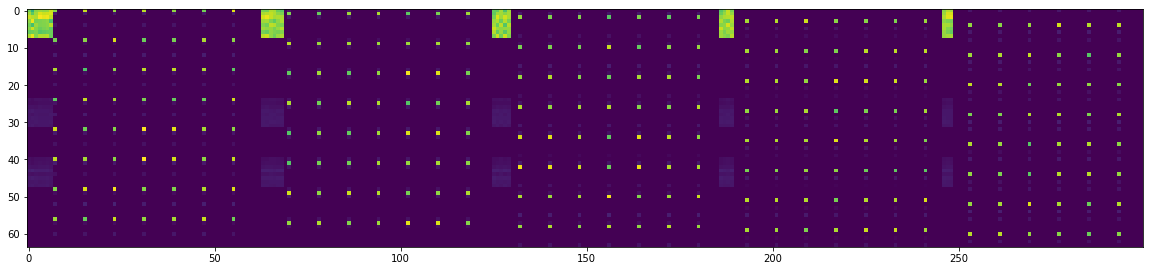

In [40]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

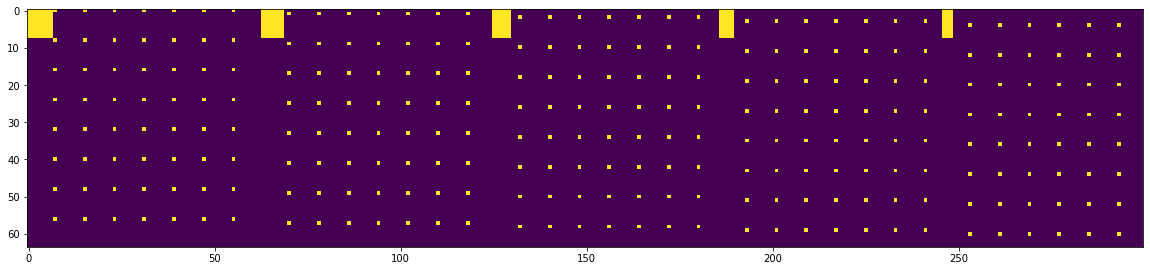

In [41]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

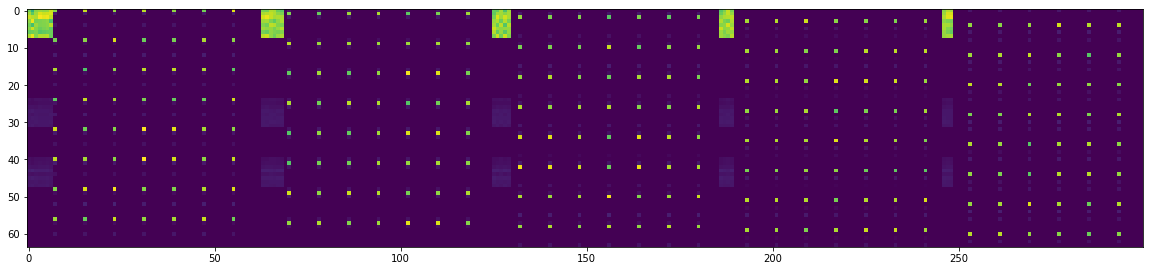

In [42]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

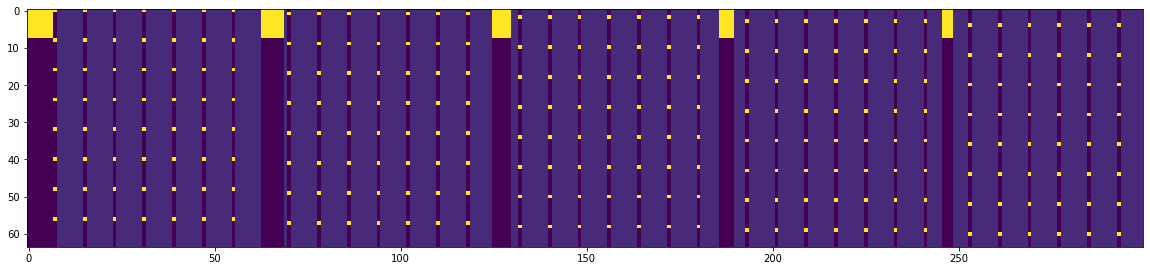

In [43]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])